# Get graph embeddings from GraphSage output

In [87]:
%matplotlib notebook
import graph_tool
import snap
import numpy as np
from pymongo import MongoClient, GEOSPHERE
from matplotlib import pylab as plt
import operator
from IPython.display import HTML, display
import tabulate
from scipy import stats
import collections
from os import path
import json

In [88]:
# Database client

client = MongoClient('localhost', 27272)
db = client.test
business = db.business
reviews = db.review
users = db.users

In [89]:
top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']

dir_format = '/yagami/lyl/project/GraphSAGE/unsup-GraphSAGE_input/{}_graphsage_mean_small_0.000010'

## Get Graph Embeddings for each cascade graph

In [90]:
business_ids = list(db.city_business.find(
        {},
        {
            '_id': 0,
            'business_id': 1
        }
    ))

In [91]:
embedding_graph = {}

for i, business in enumerate(business_ids):
    business_id = business['business_id']
    dir_name = dir_format.format(business_id)
    val_npy_loc = path.join(dir_name, 'val.npy')
    if not path.exists(val_npy_loc):
        continue
    embedding_mat = np.load(val_npy_loc)
    
    embedding_avg = np.average(embedding_mat, axis=0)
    embedding_sum = np.sum(embedding_mat, axis=0)
    embedding = np.concatenate((embedding_avg, )) # embedding_sum
    embedding_graph[business_id] = embedding

In [92]:
len(embedding_graph)

10579

## Baseline business Feature

In [93]:
business_small_path = '../yelp/business_small.json'
business_path = '../yelp/yelp_academic_dataset_business.json'

In [94]:
def parse_business_feats(path):
    embed_graph = {}
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
            bid = raw['business_id']
            feats = []
            for entity in ['stars', 'review_count', 'is_open', 'latitude', 'longitude']:
                tmp  = float(raw[entity]) if raw[entity] != None else 0.
                feats.append(tmp)
            embed_graph[bid] = np.array(feats) 
    return embed_graph
def business_id_list(path):
    id_list = []
    i = 0
    with open(path, 'r') as f:
        for line in f:
            i += 1
            id_list.append(line[:-1])
            # if i > 8000:
            #     break
    return id_list

In [95]:
business_ids = business_id_list('GraphSAGE_input/bid.txt')
embedding_graph = parse_business_feats(business_path)

## Get business popularity score from database

In [96]:
import json 

business_ranking = json.load(open('business-ranking.json'))

In [97]:
def popularity_score(rank, neighbors):
    return np.power(float(rank) / float(neighbors), 1)

In [98]:
# create a n x m dimensional matrix of embedding & value
# x: dim = 5
x = []
y = []
for i, business in enumerate(business_ids):
    business_id = business
    if business_id in embedding_graph and business_id in business_ranking:
        rank, neighbors = business_ranking[business_id]['rank'], business_ranking[business_id]['neighbors']
        x.append(embedding_graph[business_id])
        y.append(popularity_score(rank, neighbors))
x, y = np.array(x), np.array(y)

In [99]:
# normalize x
import sklearn
from sklearn.preprocessing import normalize
x_norm = x -  np.mean(x, axis = 0)
x_norm = normalize(x_norm, norm='l2')
x = x_norm

In [100]:
n, m = x.shape  # n = number of test data, m = dimension

In [101]:
indices = np.random.permutation(n)
offset_train, offset_dev, offset_test = 0, int(n * 0.6), int(n * 0.8)
train, dev, test = indices[offset_train : offset_dev], indices[offset_dev : offset_test], indices[offset_test :]

x_train, x_dev, x_test = x[train, :], x[dev, :], x[test, :]
y_train, y_dev, y_test = y[train], y[dev], y[test]

In [102]:
y_test.shape

(2603,)

## Regression

In [188]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR

In [114]:
# ground_truth score v.s. predition score
def plot_regress_viz(ground_truth, prediction):
    plt.figure()
    plt.scatter(ground_truth, prediction, alpha=0.5, s=5)
    reference_line = np.array([0, 0.5, 1])
    plt.plot(reference_line, reference_line, '--', color='grey')
    plt.xlabel('ground truth')
    plt.ylabel('prediction')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.show()
    plt.savefig('baseline.pdf')

def r2_score_result(ground_truth, prediction):
    s = r2_score(ground_truth, prediction)
    print 'r2 score is %f' % s
    return s

In [104]:
y_test

array([0.08163265, 0.28571429, 0.79861111, ..., 0.16857798, 0.14285714,
       0.841612  ])

In [ ]:
for count, degree in enumerate([2]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(solver='svd'))
    model.fit(x_train, y_train)
    y_test_output = model.predict(x_test)
    accuracy = np.sum(y_test == y_test_output)
    print y_dev.shape, accuracy
    
    
    # evaluation
    plot_regress_viz(y_test, y_test_output)
#     r2_score_result(y_test, y_test_output)

In [180]:
np.sum((y_test < 0.1) == (y_test_output < 0.1))

973

In [181]:
np.sum((y_test < 0.1))

273

In [182]:
np.sum(np.logical_and((y_test_output < 0.1), (y_test < 0.1)))

223

In [183]:
np.sum(y_test_output < 0.1)

320

In [105]:
model = make_pipeline(PolynomialFeatures(degree), MLPRegressor(hidden_layer_sizes=(1000, 1000, 300, 200, 100), activation='relu', solver='adam', alpha=0.0001, verbose=True))
model.fit(x_train, y_train)
y_test_output = model.predict(x_test)
# plot_regress_viz(y_test, y_test_output)
print r2_score_result(y_test, y_test_output)

Iteration 1, loss = 0.01345367
Iteration 2, loss = 0.00692201
Iteration 3, loss = 0.00531018
Iteration 4, loss = 0.00504613
Iteration 5, loss = 0.00432579
Iteration 6, loss = 0.00431019
Iteration 7, loss = 0.00387260
Iteration 8, loss = 0.00609954
Iteration 9, loss = 0.00420746
Iteration 10, loss = 0.00453869
Iteration 11, loss = 0.00339625
Iteration 12, loss = 0.00353607
Iteration 13, loss = 0.00379287
Iteration 14, loss = 0.00338580
Iteration 15, loss = 0.00326996
Iteration 16, loss = 0.00324579
Iteration 17, loss = 0.00359528
Iteration 18, loss = 0.00299794
Iteration 19, loss = 0.00298998
Iteration 20, loss = 0.00308141
Iteration 21, loss = 0.00305483
Iteration 22, loss = 0.00325334
Iteration 23, loss = 0.00295169
Iteration 24, loss = 0.00328725
Iteration 25, loss = 0.00333203
Iteration 26, loss = 0.00305290
Iteration 27, loss = 0.00370426
Iteration 28, loss = 0.00317512
Iteration 29, loss = 0.00291506
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

<IPython.core.display.Javascript object>


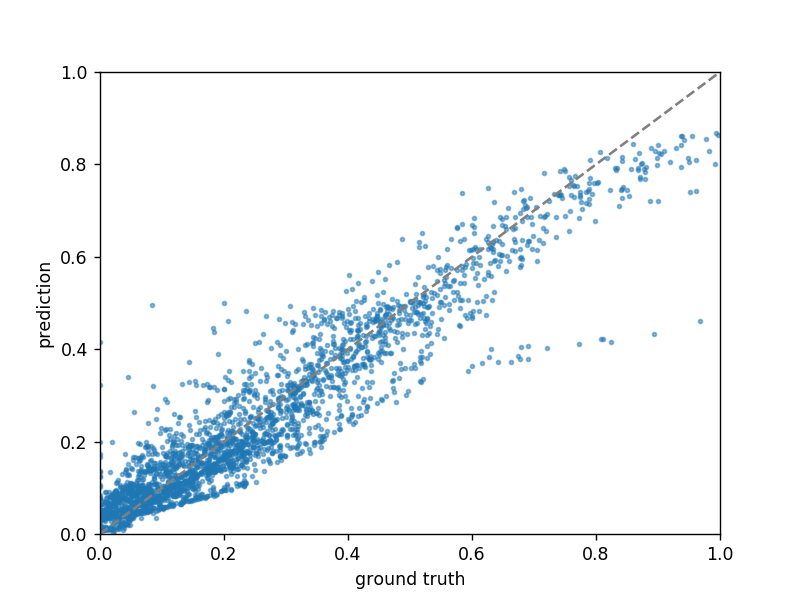

In [115]:
plot_regress_viz(y_test, y_test_output)

In [112]:
model = make_pipeline(SVR(kernel='rbf', gamma=0.01))
model.fit(x_train, y_train)
y_test_output = model.predict(x_test)
plot_regress_viz(y_test, y_test_output)
print r2_score_result(y_test, y_test_output)

NameError: name 'SVR' is not defined